In [1]:
from pathlib import Path
import typer
from loguru import logger
import numpy as np
import cv2
from PIL import Image
from dataclasses import dataclass
from typing import Tuple

from live_portrait.modules.live_portrait.live_portrait_inferencer import LivePortraitInferencer
from live_portrait.modules.utils.paths import MODELS_DIR, OUTPUTS_DIR
from live_portrait.modules.utils.constants import ModelType, SamplePart

inf = LivePortraitInferencer()



In [31]:
@dataclass
class ExpressionRanges:
    """Defines ranges for different facial expression parameters"""

    rotate_pitch: Tuple[float, float] = (-20.0, 20.0)  # Rotation range in degrees
    rotate_yaw: Tuple[float, float] = (-20.0, 20.0)
    rotate_roll: Tuple[float, float] = (-20.0, 20.0)
    blink: Tuple[float, float] = (-20.0, 20.0)  # 0 = eyes open, 1 = eyes closed
    eyebrow: Tuple[float, float] = (-40.0, 40.0)  # -1 = down, 1 = up
    wink: Tuple[float, float] = (0, 25.0)  # 0 = no wink, 1 = full wink
    pupil_x: Tuple[float, float] = (-20.0, 20.0)  # -1 = left, 1 = right
    pupil_y: Tuple[float, float] = (-20.0, 20.0)  # -1 = down, 1 = up
    aaa: Tuple[float, float] = (-30.0, 30.0)  # Mouth shapes
    eee: Tuple[float, float] = (-20.0, 20.0)
    woo: Tuple[float, float] = (-20.0, 20.0)
    smile: Tuple[float, float] = (-2, 2)
    source_ratio: Tuple[float, float] = (0.0, 1.0)
    crop_factor: Tuple[float, float] = (1.5, 2.5)


def generate_random_expression() -> list:
    """Generate random values for facial expressions within defined ranges"""
    ranges = ExpressionRanges()

    params = [
        ModelType.HUMAN.value,
        np.random.uniform(*ranges.rotate_pitch),
        np.random.uniform(*ranges.rotate_yaw),
        np.random.uniform(*ranges.rotate_roll),
        np.random.uniform(*ranges.blink),
        np.random.uniform(*ranges.eyebrow),
        np.random.uniform(*ranges.wink),
        np.random.uniform(*ranges.pupil_x),
        np.random.uniform(*ranges.pupil_y),
        np.random.uniform(*ranges.aaa),
        np.random.uniform(*ranges.eee),
        np.random.uniform(*ranges.woo),
        np.random.uniform(*ranges.smile),
        np.random.uniform(*ranges.source_ratio),
        0.0,
        SamplePart.ALL.value,  # Sample Parts (keeping fixed)
        np.random.uniform(*ranges.crop_factor),
    ]

    logger.info(
        f"Generated random expression parameters: {dict(zip(['model_type', 'pitch', 'yaw', 'roll', 'blink', 'eyebrow', 'wink', 'pupil_x', 'pupil_y', 'aaa', 'eee', 'woo', 'smile'], params[:13]))}"
    )

    return params


def process_image_with_random_expression(
    inferencer: LivePortraitInferencer,
    source_image: np.ndarray,
    debug: bool = False,
) -> Tuple[np.ndarray, np.ndarray]:
    """Process image with random expression parameters
    params = [
        ModelType.HUMAN.value,
        0,
        0,
        0,  # Rotate Pitch, Yaw, Roll
        0,
        0,
        0,  # Blink, Eyebrow, Wink
        0,
        0,  # Pupil X, Y
        0,
        0,
        0,  # AAA, EEE, WOO
        0,  # Smile
        1,  # Source Ratio
        sample_ratio,  # Sample Ratio
        sample_parts,  # Sample Parts
        1.7,  # Crop Factor
        source_image,
        reference_image,
        None,  # Motion link
        None,  # Optional exp
    ]
    """
    params = generate_random_expression()
    if debug:
        # orginal params 0,0
        params = [
            ModelType.HUMAN.value,
            0,
            0,
            0,  # Rotate Pitch, Yaw, Roll
            0,
            0,
            0,  # Blink, Eyebrow, Wink
            0,
            0,  # Pupil X, Y
            0,
            0,
            0,  # AAA, EEE, WOO
            0,  # Smile
            1,  # Source Ratio
            1,  # Sample Ratio
            SamplePart.ALL.value,  # Sample Parts
            1.7,  # Crop Factor
            source_image,
            None,  # Motion link
            None,  # Optional exp
        ]
    else:
        params = generate_random_expression()
        # add the source image to the params
        params.append(source_image)
        params.append(None)
        params.append(None)
    processed_image, _, _ = inferencer.edit_expression(*params)
    return processed_image, source_image

2024-12-12 11:07:01.127 | INFO     | __main__:generate_random_expression:45 - Generated random expression parameters: {'model_type': 'Human', 'pitch': 11.384131809933965, 'yaw': 19.13858915965905, 'roll': 15.439165702869744, 'blink': 17.72926618545538, 'eyebrow': 38.25676356253845, 'wink': 19.645738521689413, 'pupil_x': 19.372507928541857, 'pupil_y': -8.541497094559777, 'aaa': 21.865330695724275, 'eee': 12.902753224196267, 'woo': 3.048548401178415, 'smile': -1.7693916639667022}
2024-12-12 11:07:01.128 | INFO     | __main__:generate_random_expression:45 - Generated random expression parameters: {'model_type': 'Human', 'pitch': -7.566355640555171, 'yaw': -14.100628917129686, 'roll': -15.110016274640241, 'blink': 17.830111903758862, 'eyebrow': 21.626605680881816, 'wink': 6.42738785507338, 'pupil_x': -15.570065204325868, 'pupil_y': 15.018949622263918, 'aaa': 29.643199626938078, 'eee': 16.042091130434827, 'woo': -0.39278149076863755, 'smile': -1.6446208380864502}


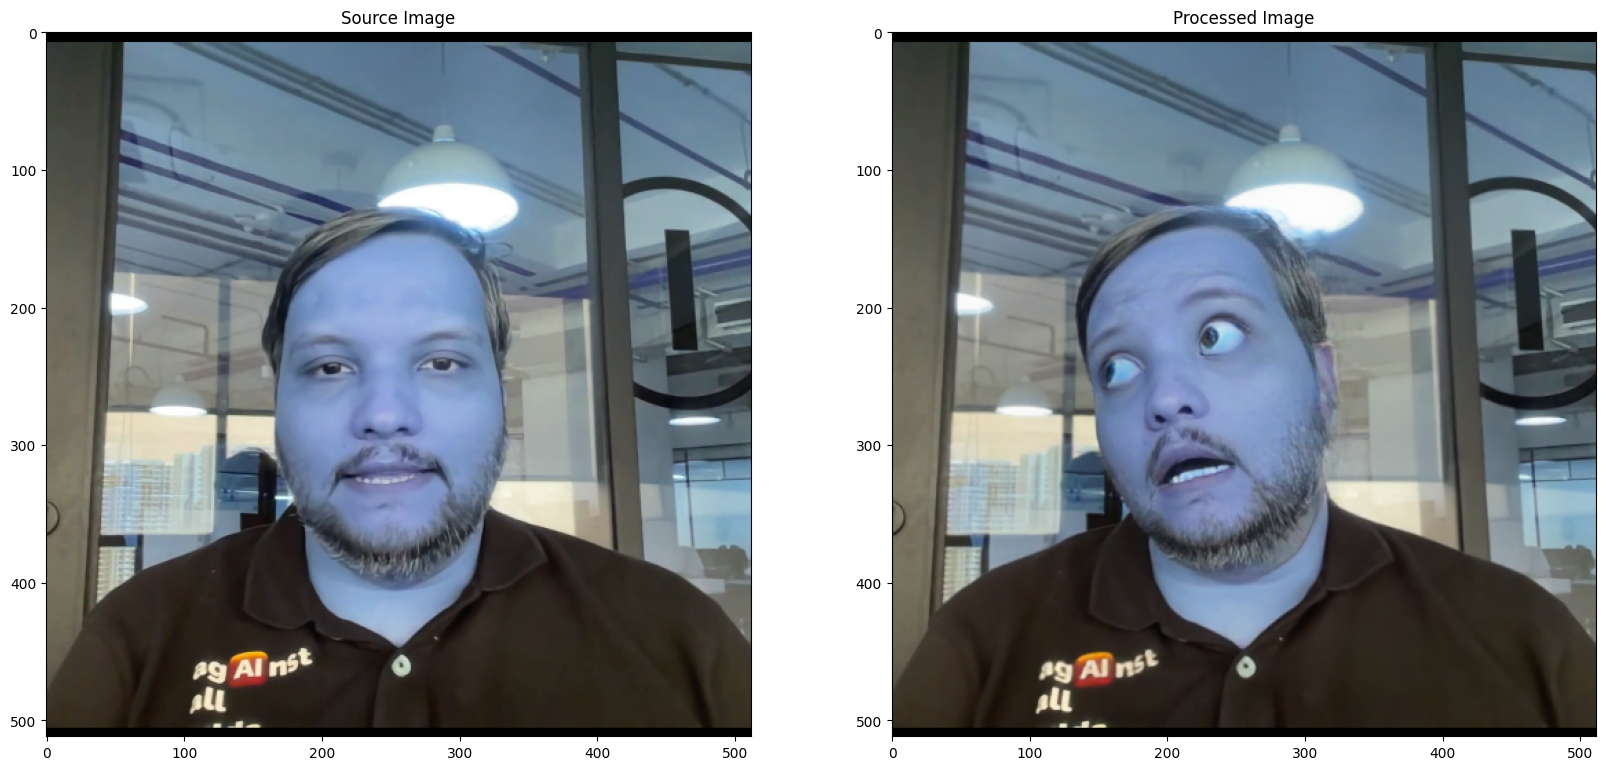

In [41]:
processed_image, source_image = process_image_with_random_expression(
    inf, np.array(Image.open("/home/pratos/lipsync/nbs/assets/avg_idx_65.png")), debug=False
)
# plot the source image and the processed image side by side using plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 10)
ax[0].set_title("Source Image")
ax[1].set_title("Processed Image")
ax[0].imshow(source_image)
ax[1].imshow(processed_image)
plt.show()